# Les données de production d'avoine par région en Ontario



<img height='250px' src='https://ontariograinfarmer.ca/wp-content/uploads/2017/09/gluten-free-oats-1024x576.jpg'>



Des données présentant les rendements de production d'avoine pour différentes régions de l'Ontario sont disponibles sur le site:

https://data.ontario.ca/dataset/ontario-field-crop-area-and-production-estimates-by-county

Les données sont pour la période de 2004 à 2012.  Les données sont accessibles sous la forme d'un fichier Excel.  
Le fichier Excel contient plusieurs onglets, un par année. Ce sont des données numériques et chronologiques.


<a href='https://data.ontario.ca/dataset/ontario-field-crop-area-and-production-estimates-by-county'>
<img src='https://drive.google.com/uc?export=view&id=1lirh_gkQatPcBZKXtpgWYBHQ2Ba-lzCs' height='300px'>  </a>
<span>&nbsp&nbsp&nbsp&nbsp</span>
<img alt='Ontario_Avoine_Excel.png' src='https://drive.google.com/uc?export=view&id=1q2-DHgVFVHZ7vMQtQR5RuVw_oWgKuciq' height='300px'>

Pour utiliser ces données, il faut : 

<pre>
Les charger --------->  Les regarder/exporer  ----------> Les nettoyer/corriger   ----------> les sauvegarder
                                ^                                |
                                |                                |
                                |                                |
                                ----------------------------------                                                        


</pre>

## Chargement des librairies python

In [ ]:
# Accès à mes fichiers sur Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My Drive/

# Installation et chargement des librairies nécessaires
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#!pip install ydata_profiling ipywidgets
#!pip install --upgrade Pillow

from ydata_profiling import ProfileReport

colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"]

## Chargement des données de rendement d'avoine

In [ ]:
# Nous allons chercher le fichier directement via l'URL
filepath = "https://data.ontario.ca/dataset/e30dc044-5f75-4f33-b63e-6326f8769bea/resource/5fe1b9cc-5c3b-4f8f-99fc-2cacf41fcf9d/download/ctyoats_f.xlsx"

# Lecture du fichier Excel spécifié par la variable filepath
f = pd.ExcelFile(filepath)
sheet_names = f.sheet_names

# Nous imprimons les noms des onglets dans le fichier
print(f'{len(sheet_names)} onglets dans le fichier: {os.path.basename(filepath)}')
print(", ".join(sheet_names))

Nous pouvons conserver tous les onglets dans une structure de données.  Nous pouvons imprimer quelques informations sur les données.

In [ ]:
# Lecture de tous les onglets du fichier Excel
# Nous les conservons dans un dictionnaire de dataframes pandas

dfs = {}

for sheet in sheet_names:  
    df = f.parse(sheet, skiprows=1)
    df.loc[:, 'Onglet'] = sheet 
    dfs[sheet] = df
    print(F'{sheet} : {df.shape[0]} rangées, {df.shape[1]} colonnes,  {list(df.columns)}')
   

Regardons les trois premières lignes du premier onglet.

In [ ]:
# Inspection de quelques onglets dans le fichier
i = 0
dfs[sheet_names[i]].head(3)

### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>

Inspecter différents onglets, le début et la fin.  Noter vos observations.



In [ ]:
# Inspecter différents onglets, le début et la fin






### Observations    
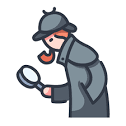

* L'année peut être récupérée dans les noms d'onglet

* Chaque onglet contient les données d'une année donnée

* Les onglets ne comportent pas tous le même nombre de rangées et deux onglets contiennent des erreurs dans leur nom.  

* Tous les onglets ont le même nombre de colonnes.

* Le header n'est pas toujours dans la première rangée, il est parfois dans la seconde.
* La colonne contenant les régions n'est pas nommée.

* Incohérence de langue (FR/EN) (oats).

* Incohérence dans le nombre de lignes entre les onglets.

* Incohérence dans le nom des régions entre les onglets.

* Incohérence dans le nom des colonnes entre les onglets.

* Incohérence pour indiquer l'absence de données ou l'absence d'ensemencement (on ne sait pas ce que signifie '-', 'x', 0). 
    * Logiquement, un rendement de 0 semble improbable si les valeurs d'acres ensemencées et d'acres récoltées ne sont pas 0. Il faudrait approfondir ceci.

* Incohérence dans les valeurs dernières lignes des onglets

* Le nom des colonnes a changé au fil du temps.  Au moins, la signification et l'ordre sont restés les mêmes.



## Plan de nettoyage

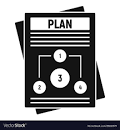

La première étape est de gérer les erreurs évidentes pour produire un jeu de données que nous pourrons explorer plus en détails. Pour l'instant, nous ne pouvons procéder à l'EDA avec le jeu de données que nous avons. 
Encore moins intégrer un autre type de données, comme les données météo.
Le processus de nettoyage est un processus itératif.  Nous ne pouvons normalement pas tout corriger du premier coup.


Quels sont les étapes ?

1. Gérer la différence entre le nombre de rangées pour pouvoir concaténer les onglets en une seule structure de données.
<em>
    * Nous savons que la dernière ligne de données contient le total pour l'Ontario
    * Nous savons que les mots 'Rendement' et 'Production' se trouvent dans la rangée contenant les noms de colonnes (header)
</em><br><br>


2. Standardiser le vocabulaire
<em>
    * Nous ne voulons pas garder les mots clés 'Division', 'County',... dans le nom des régions.
    * Nous voulons harmoniser les noms de colonnes
    * Nous voulons standardiser les valeurs nulles.
</em><br><br>


3.  Extraire les années des noms d'onglets et les ajouter aux données
<em>
    * Malgré les erreurs dans le nom des onglets, ce qui nous intéresse est l'année que nous voulons conserver.
</em><br><br>


4. Nous voulons combiner les données des différents onglets en une seule matrice.  Ce n'est pas très pratique de travailler avec 19 matrices de données.  



<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>

In [ ]:
data = pd.DataFrame()
new_cols = ['Region', 'Acres ensemencée', 'Acres récoltée', "Rendement (boisseaux à l'acre)",
            "Production ('000 boisseaux)", "Production ('000 tonnes métriques)",  "Onglet", "Annee"]


for sheet, df in dfs.items():
  
    df['Onglet'] = sheet

    # Nous vérifions si le mot-clé "Production" se trouve dans n'importe quelle colonne
    # S'il est trouvé, les noms de colonnes sont corrects, sinon, nous devons les corriger
    word_in_column = df.columns.str.contains("Production", regex=True).any()
    if word_in_column == False:
      header = df.iloc[0,:].values
      df = df.iloc[1:,:]
      df.columns = header
      
    # ... (à votre tour) - qu'est-ce qu'on fait ici 
    year = int(re.search(r'\d+', sheet).group())
    if year == 201:
      year = 2010
    df['Annee'] = year
    
    df.columns = new_cols
    
    # ... (à votre tour) - qu'est-ce qu'on fait ici 
    last_row_index = df.Region.tolist().index('Ontario')
    df = df.iloc[:last_row_index, :]

    data = pd.concat([data, df], axis=0, ignore_index=True)

data = data.loc[~data.Region.str.contains('Ontario'),:]
data = data.loc[~data.Region.str.contains('Région'),:]
data.replace('-', 0, inplace=True)
data.replace('x', 0, inplace=True)

# Optionnel. Nous pouvons renommer les colonnes pour les rendre plus lisibles avec rename
# Nous aurions pu faire cela dans la boucle plus haut en utilisant ces noms dans new_cols
new_column_names = { "Acres ensemencée": "Ensemencee",
                     "Acres récoltée": "Recoltee",
                     "Rendement (boisseaux à l'acre)": "Rendement",
                     "Production ('000 boisseaux)": "Production_boiseaux",
                     "Production ('000 tonnes métriques)": "Production_tonnes",
                     "Year": "Annee",
                     "Sheet": "Onglet"}
data.rename(columns=new_column_names, inplace=True)

Regardons de quoi a l'air notre nouvelle matrice de données.  Est-ce que les dimensions semblent bien?

In [ ]:
print('Dimension du dataframe: ', data.shape)
data.head(2)

In [ ]:
data.tail(2)

 #### Uniformisation des noms de régions
  * Retirer les totaux par régions ("Région du Nord de l'Ontario")
  * Remplacer les mots : County, Regional Municipality, District, Counties, Division, District Municipality, United Counties.
  * Que faire avec le Grand ? (Grand Sudbury -> est la ville, Sudbury est le district)

In [ ]:
data.loc[data.Region.str.contains('Brant'),:]

In [ ]:
regions = data.Region.unique()
words = []
for region in regions:
  found = [r for r in regions if region in r]
  if len(found) > 1:
    print(region, found)
    words += [r.replace(region, '') for r in found if r!=region]
words = list(set(words))

In [ ]:
words.remove('Grand ')
words = sorted(list(set(words)))
words.append(' Municipality')

def clean_region(region):
  for word in words:
      region = region.replace(word, '')
  return region

data.loc[data.Region=='Sudbury Regional Municipality', 'Region'] = 'Grand Sudbury'
data.loc[:, 'Region'] = data.Region.apply(lambda x: clean_region(x))


## Exploration des données

Maintenant que nous avons une matrice de données manipulable, nous allons explorer les données pour mieux les comprendre et corriger les erreurs restantes.

Comment ? En générant des graphiques et des statistiques

In [ ]:
format_dict = {"Annee":"{:%Y}"} #Simplified format dictionary with values that do make sense for our data
data.loc[data.Region.str.contains('Brant'),:].style.background_gradient(cmap="BuGn")

### Visualisation

La meilleure façon de comprendre un dataset est en l'explorant à l'aide de graphique.  Il est important d'identifier d'abord quelles informations et graphiques sont pertinentes.  La visualisation doit avoir une intention.

#### Heatmap

Ce graphique met en relation deux variables catégoritielles, l'année et la région et une variable continue, le rendement.

In [ ]:

mx = data.pivot_table(index="Annee", columns="Region", values="Rendement").fillna(0)
fig = plt.figure(figsize=(12, 5))
sns.heatmap(mx, cmap="GnBu",  linewidths=.5)
plt.show()

#### Clustermap

Comme le heatmap, le graphique met en relation deux variables catégoritielles, l'année et la région et une variable continue, le rendement.
De plus, il présente un clustering hiérarchique des années et des régions basé sur le rendement.  Les années ayant des profils de rendement similaires parmi les régions ont positionnés plus près et les régions ayant des profils de rendement similaires parmi les années sont positionnés plus près.

Nous observons trois groupes de régions principaux, ce qui ressort est le motif de valeurs de rendement nulles.   Pour les années, il y a 2 groupes, guidés par le même critère.  Qu'est-il arrivé entre 2016 et 2019 ?

In [ ]:

mx = data.pivot_table(index="Annee", columns="Region", values="Rendement").fillna(0)
fig = plt.figure(figsize=(10, 4))
sns.clustermap(mx, cmap="GnBu",  linewidths=.5)
plt.show()
    

#### Pairplot

Ce graphique met en relation deux variables.  Il permet de voir qualitativement si des variables sont corrélées en entre elles en plus de présenter la distribution de chaque variable.  Nous pouvons voir que :

* la distribution du rendement est bimodale.  
    * il suit une distribution normale 
    * il y une grande proportion de valeurs égales à 0

* le nombre d'acres récoltés est corrélé au nombre d'acres ensemencés.
* la production de boiseaux est proportionnelle au nombre d'acres ensemencées
* le rendement n'est corrélé avec aucune des autres variables
* il y a un grand nombre d'entrées à 0

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.pairplot(data)
plt.show()

#### Graphes de distribution

L'exploration des différentes variables peut révéler des interrogations au niveau de la logique.  Ici, est-ce normal d'avoir des cas où l'on récolte plus que l'on ensemence? 

L'histogramme du pourcentage d'acres récoltées versus ensemencées nous montre très rapidement les cas d'exception à investiguer.

In [ ]:
fig = plt.figure(figsize=(5, 3))
plt.hist(data["Recoltee"]/data["Ensemencee"]*100, bins=40, color='#2A8CC4'
         , edgecolor='black', linewidth=0.5)

plt.axvline(x=100, c='#40BEAD', linestyle='--')
plt.title("Pourcentage d'acres Recoltées/Ensemencées")
plt.xlabel("Pourcentage (Récoltées/Ensemencées)")
plt.show()

In [ ]:
data.loc[(data["Recoltee"]==0)&(data["Ensemencee"]>0),:]

In [ ]:
data.loc[data["Recoltee"]>data["Ensemencee"],:]

In [ ]:
# Rendement moyen par region
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[data.Rendement>0, :].groupby("Region").agg({"Rendement": "mean"}).sort_values(by="Rendement", ascending=False).plot(kind='bar', ax=ax, color=colors[0])
plt.ylabel('Rendement moyen (boiseaux/acre)')
plt.show()

In [ ]:
# Nombre d'annees pour lesquelles les rendements sont supérieurs à 0
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[data.Rendement>0, :].groupby("Region").agg({"Rendement": "count"}).sort_values(by="Rendement", ascending=False).plot(kind='bar', ax=ax, color=colors[0])
plt.ylabel("Nombre d\'années")
plt.title("Nombre d\'années pour lesquelles les rendements sont supérieurs à 0")
plt.show()

#### Boxplot 

Le boxplot nous permet de facilement mettre en relation des distributions.  Nous pouvons donc avoir un aperçu du rendement par région et par année.
Le boxplot présente la valeur médiane et les valeurs quantiles ansi que les valeurs aberrantes de la distribution.

Comme nous nous intéressons au rendement, il est intéressant de le définir avec son équation : 

$ Rendement = \frac {Production}{Acres_{récoltés}} *1000$

où le $Rendement$ est en boiseaux à l'acre.

In [ ]:
sns.boxplot(data, y='Rendement', x='Annee', color=colors[1])
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine par région")
plt.title(f"Les données proviennent de {len(data.Region.unique())} régions", fontsize=10)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data,  y='Rendement', x='Region', color=colors[1])
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine par région")
plt.title("Les données représentées sont de 2004-2022", fontsize=10)
plt.show()

Nous pouvons revisiter le heatmap et inclure la valeur de rendement comme annotation.

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
mx = data.pivot(index="Annee", columns="Region", values="Rendement")
sns.heatmap(mx, annot=True, ax=ax, fmt=".0f", cmap='GnBu', linewidths=.5)
plt.title('Rendement par région et par année')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
for i,region in enumerate(['Grey', 'Bruce', 'Waterloo']):
    data.loc[data.Region==region,:].plot(x='Annee', y='Rendement', label=region, marker='o', ax=ax, color=colors[i])

plt.xticks(data.Annee.unique(), rotation=90)
plt.ylabel('Rendement (boiseaux/acre)')
plt.title(f'Rendement - avoine')
plt.ylim(0,data.Rendement.max()+5)
plt.show()

In [ ]:
report = ProfileReport(data, title="Profiling Report")
report

## Filtre et sauvegarde du fichier de données nettoyées

In [ ]:
# Nous voulons conserver les régions pour lesquelles nous avons au moins 3 années de données
# Encore une fois, que signifie une valeur de 0, ce n'est pas clair
n = 3
mx = data.pivot_table(index="Annee", columns="Region", values="Rendement")
region_to_keep = mx.columns[mx.apply(lambda x:x==0).sum() < n]
print(f'Nous conservons {len(region_to_keep)} sur un total de {mx.shape[1]} régions')

data_filtered =  data.loc[data.Region.isin(region_to_keep),:]
print(f"Nous avions {data.shape[0]} rangées, nous en gardons  {data_filtered.shape[0]}")

In [ ]:
data.to_csv('avoine_dataset.csv')

Regardons le nouvel heatmap de nos données filtrées

In [ ]:

fig, ax = plt.subplots(figsize=(20,5))
mx = data_filtered.pivot(index="Annee", columns="Region", values="Rendement")
sns.heatmap(mx, annot=True, ax=ax, fmt=".0f", cmap='BuGn', linewidths=.5)
plt.title('Rendement par région et par année') 
plt.show()

In [ ]:
def plot_subset(data, x, y, values, values_col, y_units='', x_units='', capture_plot=False):            
    '''
    Graphique de y en fonction x pour les valeurs spécifiées
    Exemple : 
    plot_subset(data, x='Annee', y='Rendement', values=['Sudbury', 'Grand Sudbury'],
                values_col='Region', y_units='boiseaux/acre')
    '''
    _, ax = plt.subplots(figsize=(5,3))
      
    for value in values :
        tmp = data.loc[data[values_col]==value, :]
        tmp.plot(x=x, y=y, label=value, marker='o', ax=ax)
        
    plt.xticks(data[x].unique(), rotation=90)
    plt.ylim(data[y].min()-5, data[y].max()+5)
    plt.ylabel(f'{y.title()} ({y_units})')
    plt.xlabel(f'{x.title()} ({x_units})')
    plt.title(f'{y.title()} par {values_col.lower()} en fonction de(s) {x.lower()}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
    plt.show()


In [ ]:
plot_subset(data, x='Annee', y='Rendement', values=['Sudbury', 'Grand Sudbury'],
                values_col='Region', y_units='boiseaux/acre')

## À votre tour
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>
Quelle autre visualisation pourriez-vous faire pour mieux comprendre les données ?



In [ ]:
fig = plt.figure(figsize=(10, 5))


plt.show()

## À votre tour
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>

Ce n'est pas tout de crééer des graphiques, il faut aussi les interpréter. Qu'est-ce que vous pouvez dire sur les données ?